### Modèle CNN avec intégralité des images

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

import gradcam

In [2]:
src_img = '../images_mendeley/dataset_redim/'

In [3]:
def preprocess_input(img):
    return img/255

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [4]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [5]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


#### Convolutional neural Network

In [6]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

In [7]:
#Couches 
model =  Sequential()
model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=8,activation='softmax')) #8 Classes
#Compilation
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
#Entrainement
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 617s 2s/step - loss: 1.0501 - accuracy: 0.6093 - val_loss: 0.6698 - val_accuracy: 0.7609
Epoch 2/16
342/342 [==============================] - 615s 2s/step - loss: 0.5063 - accuracy: 0.8179 - val_loss: 0.4624 - val_accuracy: 0.8329
Epoch 3/16
342/342 [==============================] - 581s 2s/step - loss: 0.3503 - accuracy: 0.8758 - val_loss: 0.3350 - val_accuracy: 0.8713
Epoch 4/16
342/342 [==============================] - 581s 2s/step - loss: 0.2739 - accuracy: 0.9050 - val_loss: 0.3129 - val_accuracy: 0.8910
Epoch 5/16
342/342 [==============================] - 561s 2s/step - loss: 0.2220 - accuracy: 0.9231 - val_loss: 0.2817 - val_accuracy: 0.8987
Epoch 6/16
342/342 [==============================] - 534s 2s/step - loss: 0.1796 - accuracy: 0.9394 - val_loss: 0.2766 - val_accuracy: 0.9020
Epoch 7/16
342/342 [==============================] - 532s 2s/step - loss: 0.1436 - accuracy: 0.9516 - val_loss: 0.2842 - val_accuracy: 0.9046

##### Prédictions sur données d'évaluation

In [9]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [10]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.81      0.95      0.88       222
  eosinophil       0.98      0.96      0.97       627
erythroblast       0.96      0.89      0.92       311
          ig       0.86      0.84      0.85       590
  lymphocyte       0.86      0.99      0.92       236
    monocyte       0.91      0.85      0.88       302
  neutrophil       0.95      0.95      0.95       682
    platelet       1.00      0.99      0.99       449

    accuracy                           0.93      3419
   macro avg       0.92      0.93      0.92      3419
weighted avg       0.93      0.93      0.93      3419



> Précision de 93% 
>
> Mauvais score sur les ig et monocyte (86%)
> * Mauvaise précision sur les ig (80%) mais bon rappel : inclut d'autres classes
> * Mauvais rappel sur les monocytes mais bonne précision : mal détecté mais quand classifié monocyte, bonne précision
>
> Trés bon score sur les eosinophil (97%)  et platelet (99%), ainsi que neutrophil (96%)

#### GRADCAM
* Identifier les zones de l'image utilisée pour la classification

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [12]:
img_size = (224, 224)
last_conv_layer_name = "conv2d_1"

In [13]:
# Remove last layer's softmax
model.layers[-1].activation = None

#### Visualisation GRADCAM par classe

##### Basophil

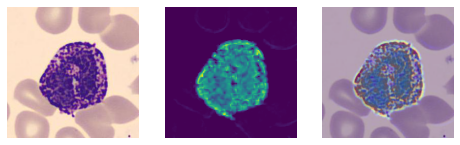

In [15]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BA_200697.jpg', img_size, model, last_conv_layer_name)

> Prise en compte de la cellule entière
>
> Score 91% : précision 95%, rappel 87%

##### Eosinophil

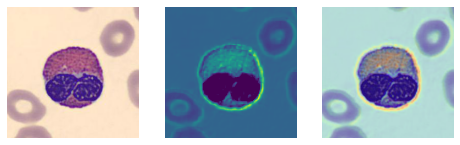

In [16]:
gradcam.display_headmap(preprocess_input, src_img+'N_EO_40758.jpg', img_size, model, last_conv_layer_name)

> Prise en compte du cytoplasme principalement et autour cellule
>
> Score 97% : précision 99%, rappel 95%

##### Erythroblast

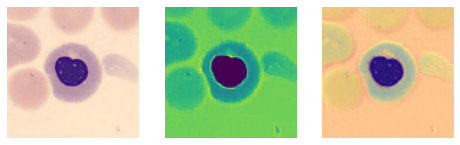

In [17]:
gradcam.display_headmap(preprocess_input, src_img+'N_ERB_80122.jpg', img_size, model, last_conv_layer_name)


> Prise en compte de toute l'image sauf le noyau
>
> Score 91% : précision 96%, rappel 86%

##### IG

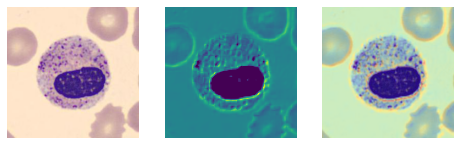

In [18]:
gradcam.display_headmap(preprocess_input, src_img+'N_MMY_19855.jpg', img_size, model, last_conv_layer_name)

> Prise en compte de toute l'image sauf le noyau 
>
> Score 86% : précision 80%, rappel 94%

##### Lymphocyte

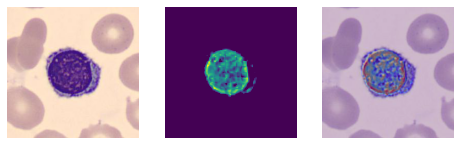

In [19]:
gradcam.display_headmap(preprocess_input, src_img+'N_LY_99706.jpg', img_size, model, last_conv_layer_name)

> Prise en compte du noyau seulement
>
> Score 90% : précision 83%, rappel 98%

##### Monocyte

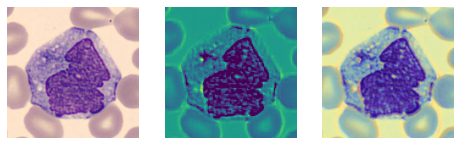

In [20]:
gradcam.display_headmap(preprocess_input, src_img+'N_MO_60562.jpg', img_size, model, last_conv_layer_name)

> Prise en compte du cytoplasme mais également autour cellule
>
> Score 86% : précision 96%, rappel 78%

##### Neutrophil

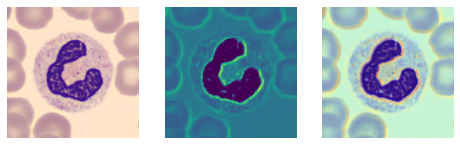

In [21]:
gradcam.display_headmap(preprocess_input, src_img +'N_BNE_53394.jpg', img_size, model, last_conv_layer_name)

> Prise en compte de toute l'image sauf le noyau, mais importance du contour du noyau
>
> Score 96% : précision 97%, rappel 95%

##### Platelet

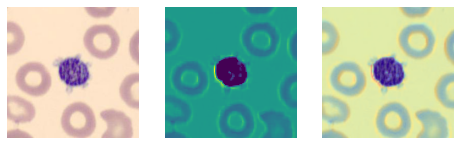

In [22]:
gradcam.display_headmap(preprocess_input, src_img +'N_PLATELET_4736.jpg', img_size, model, last_conv_layer_name)

> Prise en compte de toute l'image sauf le noyau
>
> Score 99% : précision 99%, rappel 100%